In [2]:
# Show plots within the noteboook
%matplotlib inline 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Required system Libraries 
import sys, os, datetime, time
import random
import cPickle as pickle
from pprint import pprint

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Numeric libraries
import pandas as pd
import numpy as np 

# Scikit learn stuff
from sklearn.externals import joblib

# Database connectors
from memsql.common import database
import urllib, json
from urlparse import urlparse

# orchid-ml
from orchid_ml import MutationMatrix
from orchid_ml import load_matrix


# Options for modeling (mimics the options argparse class)
class options:
    prostate_dbi = 'REDACTED'
    tag          = 'SVMv4_original_20171107' # A name for this dataset, available upon request
    lookup_names = False    # Slow lookup of gene names if not present
    std_by_len   = True     # Wether to downweight mutation scores by their gene lengths
    #scale_by     = 'scaler' # Only scaler is used now
    n_probes     = 7034     # A target number of loci to design probes for
    
os.chdir("../"+options.tag)

In [3]:
#Now in orchid.ml

## Accent Grey: #2e3436
## Muted Grey : #b2bec3
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#fca50e"]
#flatui = ["#5deec5", "#85eceb", "#77bafc", "#a29dfb", "#fee9ab", "#fd9e4d", "#f8b1a2", "#fd7777", "#fb7ba8"]
flatui = ["#22cec8", "#1cb794", "#1a86e0", "#6c61e4", "#fcca75", "#fd9e4d", "#df7059", "#d43237", "#e64793"]
pal = sns.color_palette(flatui)

In [4]:
# Look up an ensembl_id gene name using their REST API
def get_gene_name(mutation_id):
    url = "https://dcc.icgc.org/api/v1/mutations/%s/genes" % (mutation_id)
    response = urllib.urlopen(url)
    data = json.loads(response.read())
    if data['hits']==[]:
        return (None, None)
    return (data['hits'][0]['id'], data['hits'][0]['symbol'])

# A plotting function to make nicer boxplots of number of mutations
#   by binning 'Length', or 'log(Length)' (bin_on) 
#   into a desired number of bins (bin_on)
# df must contain 'gene_name' and 'Transcript Length'
def plot_counts(df, bin_on='length', bin_no=15, palette=pal):
    # Get mutations per gene
    mpg = df['gene_name'].value_counts()
    # Get maximum transcript size per gene
    mxl = df[['gene_name','Transcript Length']].groupby('gene_name').max()
    # Merge the two, and add log(length)
    df = pd.DataFrame(mpg).merge(mxl, how='left', left_index=True, right_index=True)
    df.columns = ['number', 'Length']
    df['log(Length)'] = np.log10(df['Length'])
    # Divide into bin_no number of bins
    df = df.dropna(subset=[bin_on])
    bins = pd.cut(df[bin_on], bin_no, labels=range(1,bin_no+1), retbins=True)[0]
    bins = pd.DataFrame(bins)
    bins.columns = ['bin']
    # Merge dataframe with bin membership
    df = df.merge(bins, how="left", left_index=True, right_index=True)
    
    # Set up the plot
    sns.set_context("talk", font_scale=1.8)
    fig, ax = plt.subplots(figsize=(11.7, 8.27))
    
    # Define colors colors
    colors = sns.color_palette(palette, bin_no).as_hex()

    # Define flier properties
    flierprops = dict(
                        marker='o', 
                        markersize=8, 
                        linestyle='none', 
                        linewidth=2.5,
                     )
    # And generate the boxplots
    ax = sns.boxplot(
                        x='bin', 
                        y='number', 
                        data=df, 
                        whis=1.5, 
                        linewidth=2.5,
                        palette=palette,
                        flierprops=flierprops,
                    )
    
    # Modify the axes a bit
    ax.set(xlabel='Bin (%s)' % bin_on, ylabel='Mutations per Gene')
    plt.yticks(xrange(0,21,2))
    ax.set_ylim(0,20)
    sns.despine()

    medians = df.groupby(['bin'])['number'].median().values
    median_labels = [str(np.round(s, 2)) for s in medians]

    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(
                pos[tick], 
                0.3, #medians[tick] + 0.02, 
                median_labels[tick], 
                horizontalalignment='center', 
                size='xx-small', 
                color=colors[tick]
               )
    
    # Only color the outside of the boxplots
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')
        artist.set_zorder(10)

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            line.set_mew(1)

            line.set_mfc((1,1,1,.3))
    return df


# Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
# Loop over them here, and use the same colour as above
#for j in range(i*6,i*6+6):
#    line = ax.lines[j]
#    line.set_color(col)
#    line.set_mfc((1,1,1,.3))
#    line.set_markeredgecolor(col)
#    line.set_markeredgewidth(1)

### Load model and mutation scores (distances)

In [5]:
%%time 
mutations = None
# Load the final model data
mutations = load_matrix("prostate23_final.pkl")
# Make a copy of the original data structure as we modify the original
all_mutations = mutations.copy()

CPU times: user 1min 46s, sys: 9.81 s, total: 1min 55s
Wall time: 2min 56s


In [6]:
# Focus just on the enriched mutations and rank by distance
mutations = mutations[mutations['Distance']>0]
mutations = mutations.sort_values(by='Distance', ascending=False)
# Add a log(distance) column (natural log)
mutations['Log Distance'] = np.log(mutations['Distance'])
# Drop any duplicates
print mutations.shape
mutations = mutations.drop_duplicates()
print mutations.shape

(147181, 306)
(147181, 306)


### Lookup gene and consequence information 

In [7]:
%%time
# 
# This may cause the mutation list to expand significantly depending on the number of consequences per mutation
# This can go over the transaction limit of some databases, so do this in 50K chunks
chunk = 50000
print "Annotating...",
gene_info = None
for i in xrange(0, mutations.shape[0]+1, chunk):
    #print i
    syntax = """
        SELECT c.mutation_id, c.gene_id, c.gene_name, c.consequence_type
        FROM consequence AS c 
        WHERE c.mutation_id IN ('%s') 
    """ % ("','".join(list(mutations['mutation_id'][i:i+chunk])))
    gene_info = pd.concat([gene_info, pd.DataFrame(pd.read_sql(syntax, options.prostate_dbi))])
print "done"

Annotating... done
CPU times: user 336 ms, sys: 75.1 ms, total: 411 ms
Wall time: 1.59 s


In [8]:
# Drop some unnecessary columns
mutations = \
mutations[['mutation_id','chromosome', 'start', 'end','Distance', 'Log Distance']]

In [9]:
# And merge with the gene info
mutations = \
mutations.merge(gene_info, how='left', left_on='mutation_id', right_on='mutation_id')
mutations.shape

(939995, 9)

In [10]:
# Drop duplicates and re-sort
mutations = mutations.drop_duplicates()
mutations.sort_values(by='Distance')
mutations.shape

(487177, 9)

In [11]:
# Show
mutations.head(10)

,mutation_id,chromosome,start,end,Distance,Log Distance,gene_id,gene_name,consequence_type
0,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000182511,FES,missense_variant
1,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000140564,FURIN,downstream_gene_variant
2,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000182511,FES,3_prime_UTR_variant
3,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000182511,FES,intron_variant
4,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000182511,FES,downstream_gene_variant
6,MU3895825,15,91428783,91428783,23.649174,3.163328,ENSG00000182511,FES,upstream_gene_variant
10,MU3895825,15,91428783,91428783,23.649167,3.163328,ENSG00000182511,FES,missense_variant
11,MU3895825,15,91428783,91428783,23.649167,3.163328,ENSG00000140564,FURIN,downstream_gene_variant
12,MU3895825,15,91428783,91428783,23.649167,3.163328,ENSG00000182511,FES,3_prime_UTR_variant
13,MU3895825,15,91428783,91428783,23.649167,3.163328,ENSG00000182511,FES,intron_variant


In [22]:
%%time
# Look up gene names if requested
to_lookup = mutations[(mutations['consequence_type']!='intergenic_region') & \
                      (mutations['gene_name'].isnull())]
if options.lookup_names: 
    print "Looking up %d unknown gene names" % to_lookup.shape[0],
    for i,g in to_lookup.drop_duplicates(subset='mutation_id').reset_index().iterrows():
        if i%10==0:
            print '.',
        #print "Looking up %s" % g['mutation_id']
        id_, sym = get_gene_name(g['mutation_id'])
        mutations['gene_id'][mutations['mutation_id']==i] = id_
        mutations['gene_name'][mutations['mutation_id']==i] = sym
else: 
    print "Ignoring"

54 unknown gene names...
Looking up 54 unknown gene names . . . . . .CPU times: user 1min 14s, sys: 99.2 ms, total: 1min 14s
Wall time: 1min 30s



In [23]:
# A break down of consequence type counts
mutations['consequence_type'].value_counts()

downstream_gene_variant            117659
upstream_gene_variant              103520
missense_variant                    90770
intron_variant                      77785
3_prime_UTR_variant                 38807
synonymous_variant                  34315
intergenic_region                    9513
5_prime_UTR_variant                  9076
stop_gained                          3210
5_prime_UTR_premature_start_cod      1583
splice_region_variant                 490
start_lost                            251
stop_lost                             135
intragenic_variant                      5
initiator_codon_variant                 4
Name: consequence_type, dtype: int64

In [24]:
# Re rank mutations by distance
ranked_mutations = mutations.copy().sort_values('Distance', ascending=False)

### Adjust scores based on gene length

In [25]:
# If standardizing by length, show a histogram of scale factors
if options.std_by_len:
    ucsc_dbi = "mysql://genome@genome-mysql.cse.ucsc.edu:3306/hg19"
    query = """
        SELECT X.geneSymbol, K.name as transcript, 
        K.chrom, (K.txEnd - K.txStart) as transcriptLen 
        FROM kgXref as X, knownGene as K 
        WHERE X.geneSymbol IN ('%s') 
        AND X.kgId = K.name
    """ % "', '".join(ranked_mutations['gene_name'].dropna().unique())
    gene_lengths = pd.read_sql(query, ucsc_dbi)
    gene_lengths = pd.DataFrame(gene_lengths.groupby('geneSymbol')['transcriptLen'].max())
    gene_lengths.columns = ['Transcript Length']
    
    gene_lengths['z-score'] = \
    (gene_lengths['Transcript Length']-(gene_lengths['Transcript Length'].mean()))\
    /(gene_lengths['Transcript Length'].std())
    gene_lengths['tanh'] = np.tanh(gene_lengths['z-score'])
    gene_lengths['scaler'] = 1-(gene_lengths['tanh']*.95)
    gene_lengths['normalizer'] = gene_lengths['Transcript Length'] / gene_lengths['z-score']

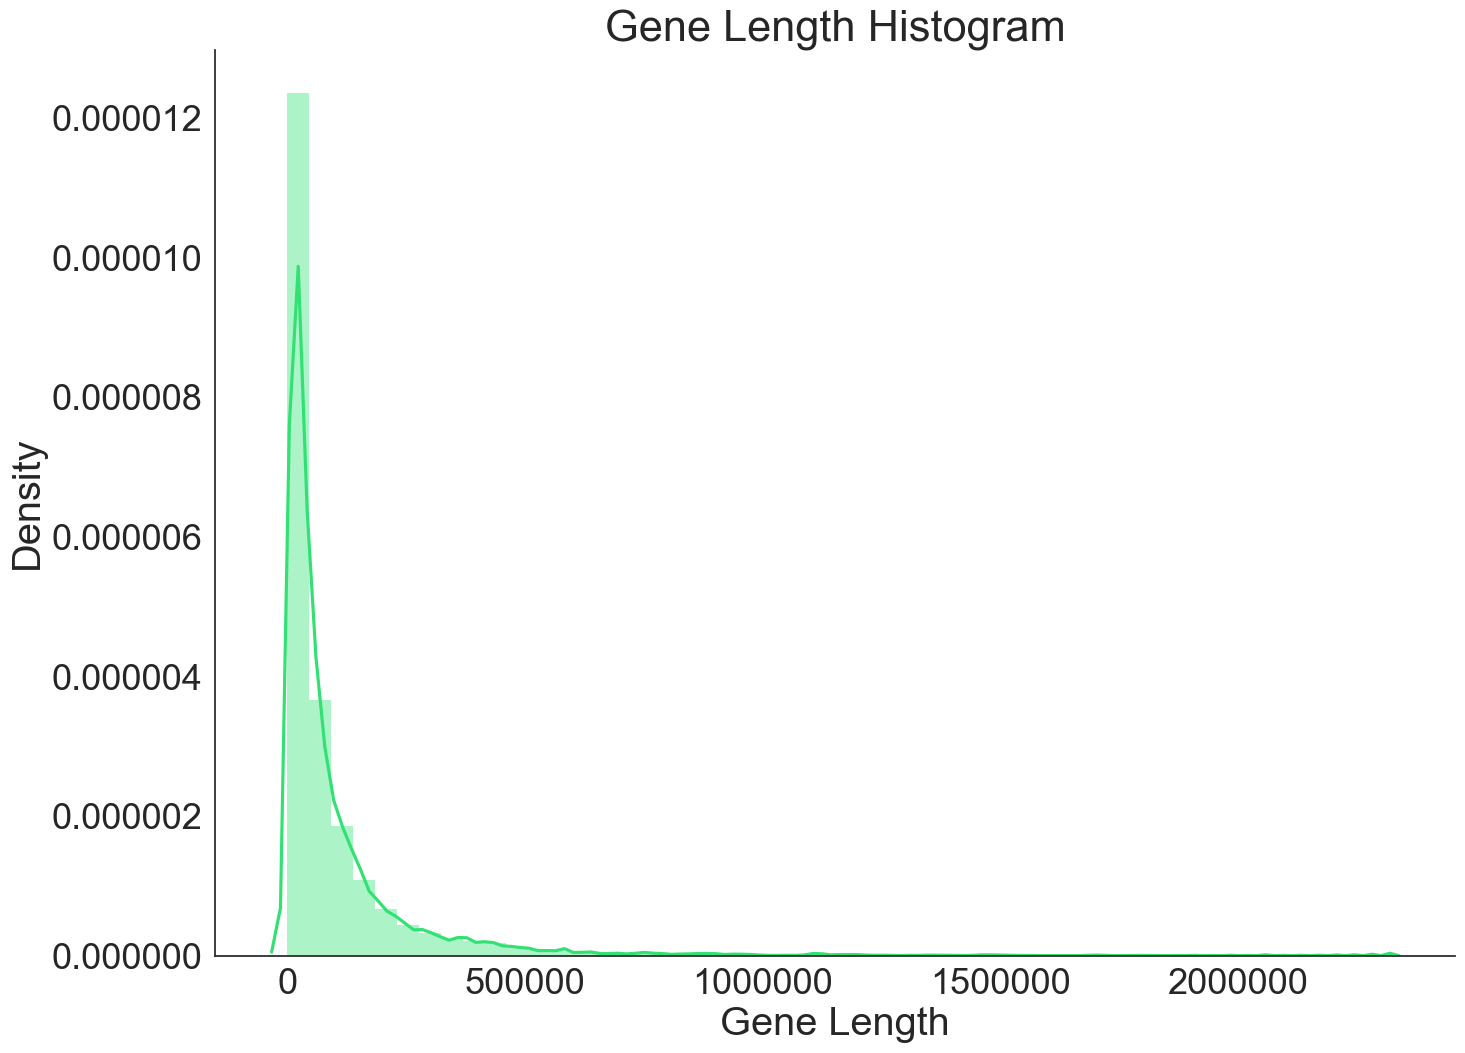

In [26]:
# If standardizing by length, show a histogram of gene lengths
if options.std_by_len:
    plt.figure(figsize=(16,12))
    sns.set_context("talk", font_scale=2)
    sns.set_style("white")
    ax = sns.distplot(gene_lengths['Transcript Length'], kde=True, color='#31E173')
    ax.set(xlabel='Gene Length', ylabel='Density', title='Gene Length Histogram')
    sns.despine()

### Supplemental Figure 2

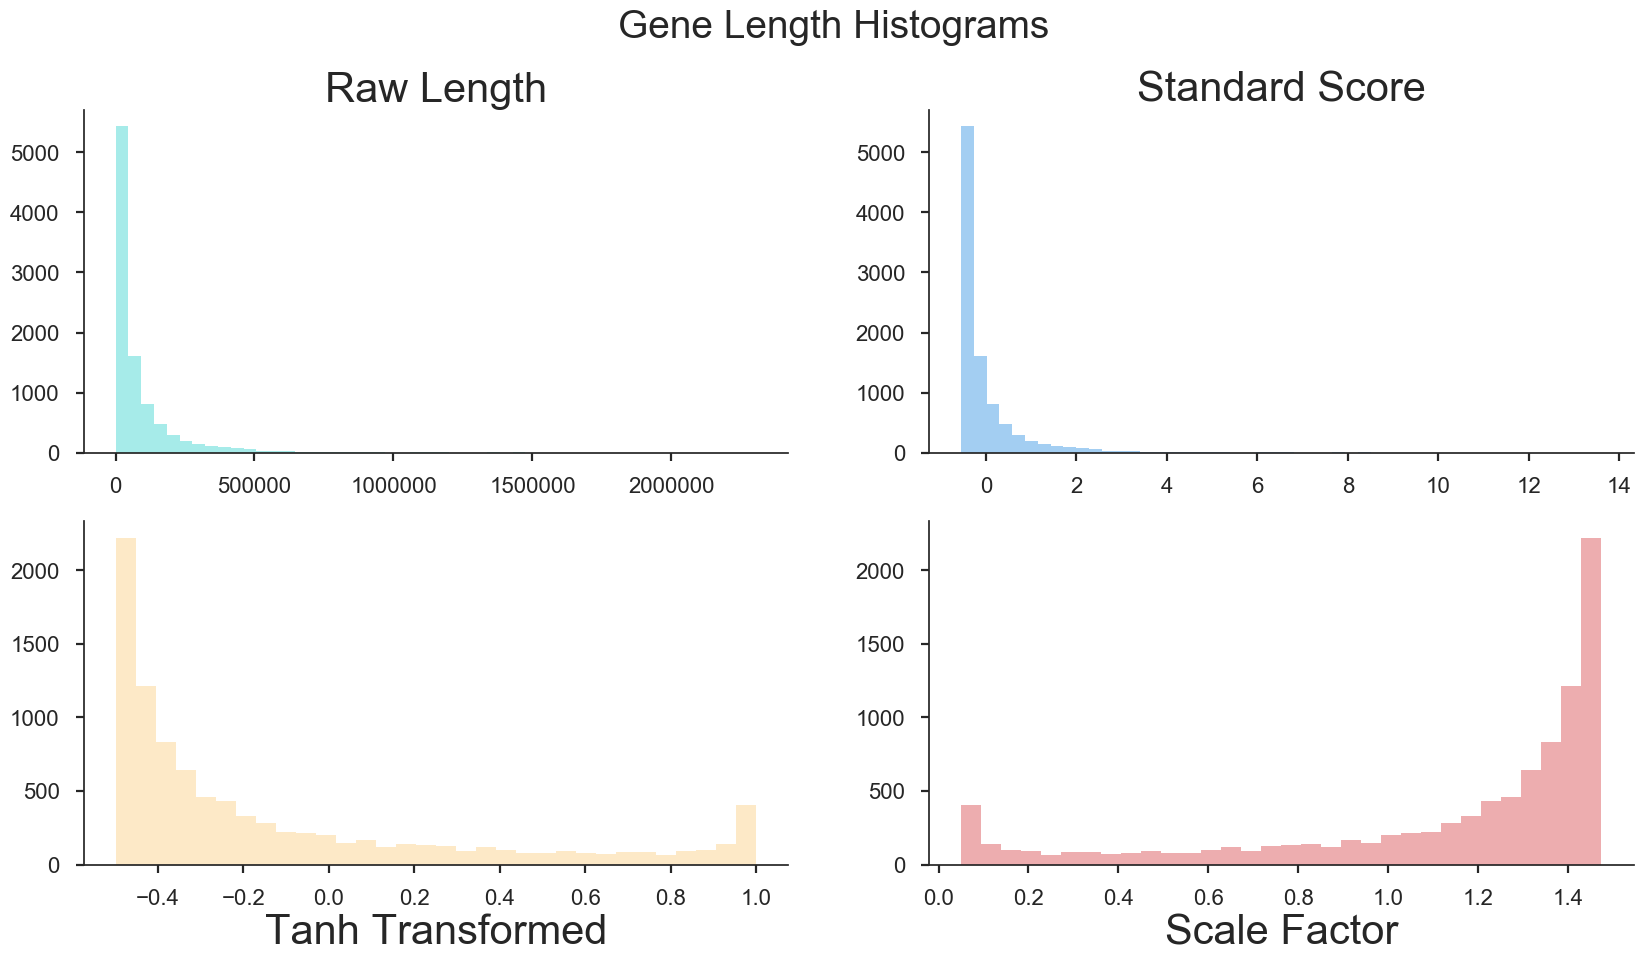

In [162]:
# Show the transforms if standardizing by length
if options.std_by_len:
    sns.set_style("white")
    sns.set_style("ticks")
    f, axes = plt.subplots(2, 2, figsize=(20,10))

    sns.distplot(gene_lengths['Transcript Length'], color='#22cec8', axlabel='', ax=axes[0][0], kde=False)
    sns.distplot(gene_lengths['z-score'],  color='#1a86e0', axlabel='', ax=axes[0][1], kde=False)
    sns.distplot(gene_lengths['tanh'],     color='#fcca75', axlabel='', ax=axes[1][0], kde=False)
    sns.distplot(gene_lengths['scaler'],   color='#d43237', axlabel='', ax=axes[1][1], kde=False)
    #sns.distplot(gene_lengths['normalizer'], color='r', ax=axes[1, 1], kde_kws={'bw':5000000})
    #ax.set(ylabel='Density', title='Histogram')

    f.suptitle("Gene Length Histograms", fontsize=28)
    axes[0,0].set_title("Raw Length", size=30)
    axes[0,1].set_title("Standard Score", size=30)
    axes[1,0].set_xlabel("Tanh Transformed", size=30)
    axes[1,1].set_xlabel("Scale Factor", size=30)

    sns.despine()

In [28]:
# Downweight mutation scores if they come from large genes, and upweight small gene mutations
# Based on the scaler metric used above
#scale_by = options.scale_by
scale_by = 'scaler'
if options.std_by_len:
    ranked_mutations= \
    ranked_mutations.merge(gene_lengths, how="left", left_on='gene_name', right_index=True)
    ranked_mutations[scale_by] = ranked_mutations[scale_by].fillna(1)
    ranked_mutations['Scaled Distance'] = ranked_mutations['Distance'] * ranked_mutations[scale_by]
    ranked_mutations = ranked_mutations.sort_values('Scaled Distance', ascending=False)
    ranked_mutations = \
    ranked_mutations.drop_duplicates(subset=['Scaled Distance', 'mutation_id', 'gene_id'])
    print ranked_mutations.shape
    ranked_mutations.head(20)

(265308, 15)


In [29]:
# For each mutation, get it's mean distance values
mmg = ranked_mutations.groupby(['mutation_id','gene_name']).mean().reset_index()
mmg = mmg[[
            'mutation_id', 
            'gene_name', 
            'Transcript Length', 
            'Distance', 
            'Log Distance', 
            'Scaled Distance'
         ]]
mmg.head(10)

,mutation_id,gene_name,Transcript Length,Distance,Log Distance,Scaled Distance
0,MU100562,KCNJ12,43481.0,5.696561,1.739863,7.182002
1,MU100583,KCNJ12,43481.0,11.649934,2.455300,14.687783
2,MU10165919,PCDH15,1806764.0,1.928305,0.656641,0.096415
3,MU10165919,RP11-168O22.1,NaN,1.928305,0.656641,1.928305
4,MU10169762,ANK3,707229.0,1.730665,0.548506,0.088195
5,MU10208,TP53,19149.0,0.448353,-0.813130,0.621402
6,MU1029760,CTB-147C22.9,NaN,0.728778,-0.316403,0.728778
7,MU1029760,KLK8,7253.0,0.728778,-0.316403,1.051006
8,MU1029760,KLK9,9211.0,0.728778,-0.316403,1.044448
9,MU10390749,NINJ2,99294.0,5.401764,1.686726,5.088733


### Figure 2A

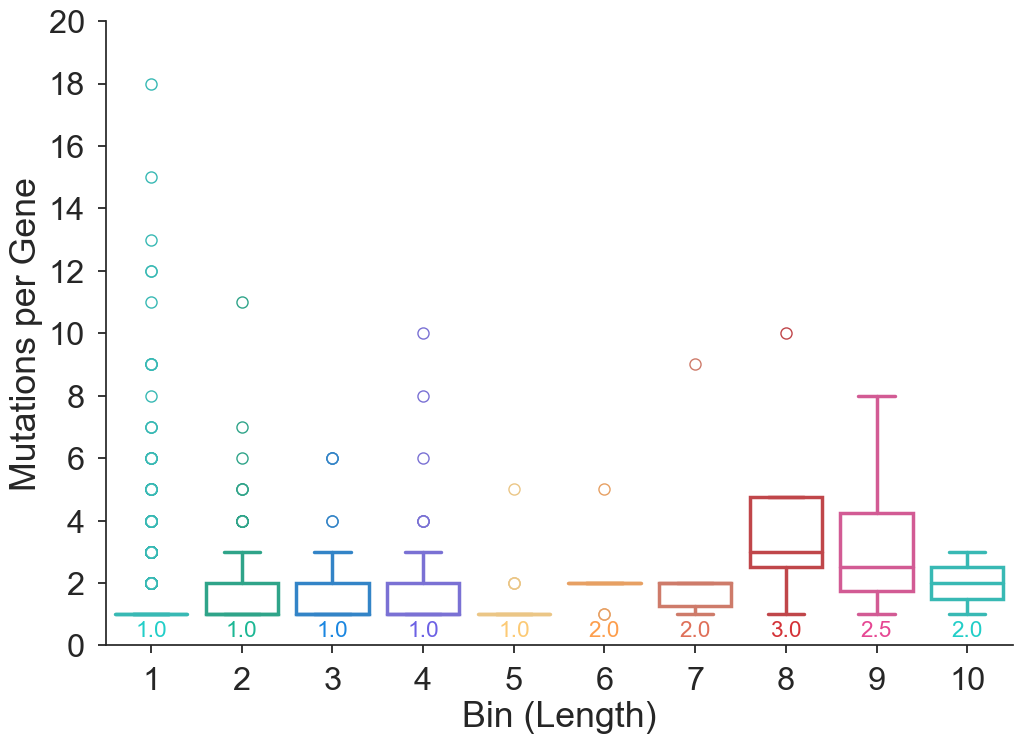

In [51]:
# Bin the genes into 
if options.std_by_len:
    before=mmg.copy().sort_values('Distance', ascending=False)[0:options.n_probes]
    bf = plot_counts(before, bin_on='Length', bin_no=10)

In [167]:
from scipy.stats import pearsonr
representation = before[['gene_name', 'Transcript Length']].drop_duplicates()\
.merge(pd.DataFrame(before.groupby(['gene_name']).size(), columns=['Number']),
       how="left", left_on='gene_name', right_index=True)\
.dropna()
cor = pearsonr(representation['Transcript Length'], representation['Number'])
print "Before length representation correlation %.3f, p-val= %.2e" % (cor)

Before length representation correlation 0.199, p-val= 6.03e-39


In [53]:
if options.std_by_len:
    print bf['bin'].value_counts(sort=False)
    print "\nNumber of genes before:  ", before['gene_name'].unique().shape[0]
    print "Number non-coding before: ", sum(before['gene_name'].isnull())
    print "Avg mutations per gene before", before.groupby('gene_name')['mutation_id'].count().mean()

1     3730
2      328
3       88
4       39
5       20
6        9
7       10
8        4
9        4
10       3
Name: bin, dtype: int64

Number of genes before:   5392
Number non-coding before:  0
Avg mutations per gene before 1.30452522255


### Figure 2B

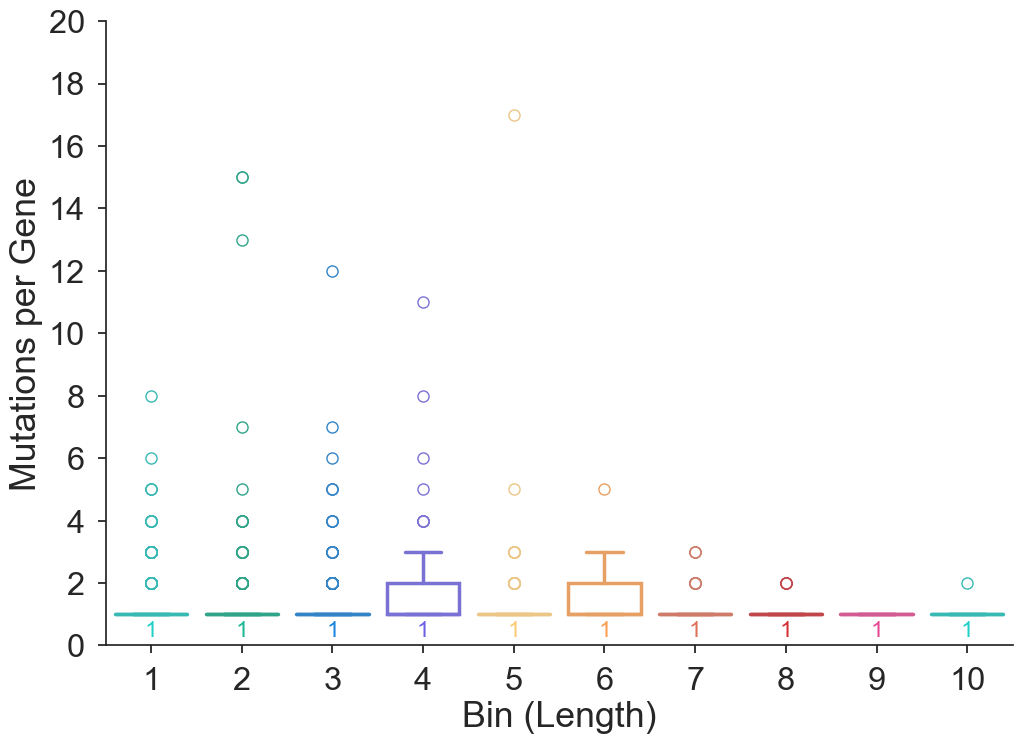

In [54]:
if options.std_by_len:
    #after  = ranked_mutations.sort_values('Scaled Distance', ascending=False).drop_duplicates(subset=['mutation_id','gene_name'])
    after = mmg.sort_values('Scaled Distance', ascending=False)[0:options.n_probes]
    af = plot_counts(after, bin_on='Length', bin_no=10)

In [168]:
representation = after[['gene_name', 'Transcript Length']].drop_duplicates()\
.merge(pd.DataFrame(after.groupby(['gene_name']).size(), columns=['Number']),
       how="left", left_on='gene_name', right_index=True)\
.dropna()
cor = pearsonr(representation['Transcript Length'], representation['Number'])
print "Before length representation correlation %.3f, p-val= %.2e" % (cor)

Before length representation correlation 0.048, p-val= 1.50e-03


In [55]:
af['bin'].value_counts(sort=False)

1     2306
2      904
3      460
4      300
5      178
6      122
7       59
8       28
9        9
10       5
Name: bin, dtype: int64

In [56]:
if options.std_by_len:
    print af['bin'].value_counts(sort=False)
    print "\nNumber of genes before:  ", after['gene_name'].unique().shape[0]
    print "Number non-coding before: ", sum(after['gene_name'].isnull())
    print "Also number of genes before?", 
    print "Avg mutations per gene before", after.groupby('gene_name')['mutation_id'].count().mean()

1     2306
2      904
3      460
4      300
5      178
6      122
7       59
8       28
9        9
10       5
Name: bin, dtype: int64

Number of genes before:   5567
Number non-coding before:  0
Also number of genes before? Avg mutations per gene before 1.26351715466


In [57]:
only_after = mutations[mutations['mutation_id']\
.isin(set(after['mutation_id']).difference(set(before['mutation_id'])))]['gene_name']\
.dropna().drop_duplicates()

In [58]:
only_before = mutations[mutations['mutation_id']\
.isin(set(before['mutation_id']).difference(set(after['mutation_id'])))]['gene_name']\
.dropna().drop_duplicates()

In [59]:
both = mutations[mutations['mutation_id']\
.isin(set(before['mutation_id']).intersection(set(after['mutation_id'])))]['gene_name']\
.dropna().drop_duplicates()

In [60]:
len(only_after)

1597

In [61]:
len(only_before)

702

In [62]:
len(both)

4833

### Coding/Noncoding Annotation

In [63]:
## Convert consequence_type to a category column
ranked_mutations['consequence_type'] = ranked_mutations['consequence_type'].astype("category")

In [64]:
high = [
         'missense_variant', 'stop_gained', 'stop_lost', 'splice_donor_variant', 
         'splice_acceptor_variant'
      ]
moderate = [
       'synonymous_variant', 'exon_variant', 'initiator_codon_variant',
       'splice_region_variant'
      ]
low = [
        '5_prime_UTR_premature_start_codon_gain_variant', '5_prime_UTR_variant', 
        '3_prime_UTR_variant', 'stop_retained_variant'
      ]
modifier = [
        'intron_variant', 'intragenic_variant', 'downstream_gene_variant', 
        'upstream_gene_variant',  'intergenic_region'
      ]

In [65]:
## Define variant priority
coding_cats = high + moderate + low
noncoding_cats = modifier

In [66]:
## Set the catgory priorities
ranked_mutations['consequence_type'].cat.set_categories(coding_cats + noncoding_cats, inplace=True)

In [67]:
%%time
## Sort the consequence_type by priority
ranked_mutations = ranked_mutations.sort_values(by=['mutation_id', 'consequence_type'])

CPU times: user 76.1 ms, sys: 16.3 ms, total: 92.4 ms
Wall time: 90.7 ms


In [68]:
%%time
## Drop missing and then the less priortized consequences
ranked_mutations = ranked_mutations.dropna(subset=['consequence_type'])
ranked_mutations = ranked_mutations.drop_duplicates(subset=['mutation_id'], keep='first')

CPU times: user 62.3 ms, sys: 15.1 ms, total: 77.4 ms
Wall time: 76.5 ms


In [69]:
#if options.std_by_len:
#    ranked_mutations['Distance'] = ranked_mutations['Scaled Distance']

ranked_mutations = ranked_mutations.sort_values(by='Distance', ascending=False)
ranked_mutations = ranked_mutations.drop_duplicates(\
        subset=['mutation_id', 'gene_name', 'consequence_type'],
        keep='first')
ranked_mutations = ranked_mutations.reset_index(drop=True)
ranked_mutations.index = ranked_mutations.index + 1

In [70]:
## Finally, add the column type and colors
ranked_mutations['type'] = None
ranked_mutations['type'][ranked_mutations['consequence_type'].isin(coding_cats)]    = 'coding'
ranked_mutations['type'][ranked_mutations['consequence_type'].isin(noncoding_cats)] = 'noncoding'

ranked_mutations['color'] = None
ranked_mutations['color'][ranked_mutations['type']=='coding'] = '#31e173'
ranked_mutations['color'][ranked_mutations['type']=='noncoding'] = 'black'

ranked_mutations['impact'] = None
ranked_mutations['impact'][ranked_mutations['consequence_type'].isin(high)]     = 'high'
ranked_mutations['impact'][ranked_mutations['consequence_type'].isin(moderate)] = 'moderate'
ranked_mutations['impact'][ranked_mutations['consequence_type'].isin(low)]      = 'low'
ranked_mutations['impact'][ranked_mutations['consequence_type'].isin(modifier)] = 'modifier'


#ranked_mutations['color'] = None
#ranked_mutations['color'][ranked_mutations['impact']=='high']     = '#EA4335'
#ranked_mutations['color'][ranked_mutations['impact']=='moderate'] = 'darkorange'
#ranked_mutations['color'][ranked_mutations['impact']=='low']      = '#FBBC05'
#ranked_mutations['color'][ranked_mutations['impact']=='modifier'] = '#4285F4'

## #31e173

### Figure 2C

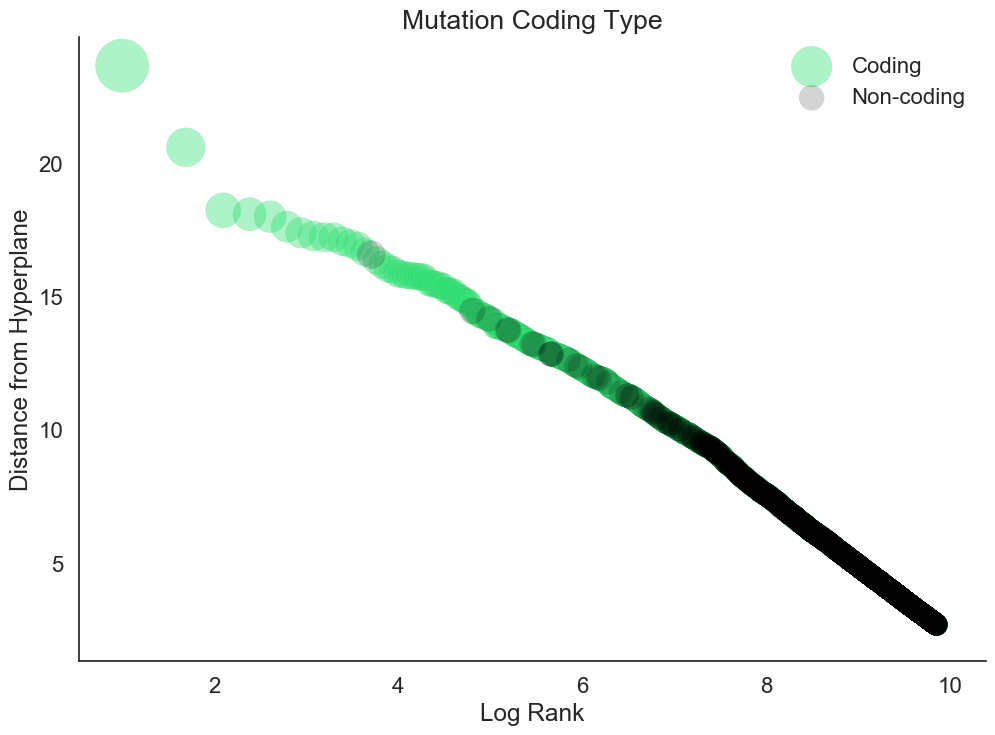

In [71]:
# PLOT
num_to_plot=options.n_probes

sns.set(style="white")
sns.set_context("poster")#, font_scale=1.5, rc={"lines.linewidth": 2})
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

cats = ranked_mutations[0:num_to_plot]
xs   = (np.log(cats.index)+1)
ys   = (cats['Distance'])
ss   = 500./(np.log(.7*(1+xs)))
leg  = []

markers = ['o','o']
alphas  = [.4,.17] 
for i,cat in enumerate(['coding', 'noncoding']):
    idx = cats['type'] == cat
    leg.append(plt.scatter(
                    xs[idx],
                    ys[idx],  
                    #s=100,
                    s=ss[idx],
                    c=cats[idx]['color'], 
                    marker=markers[i], 
                    alpha=alphas[i], 
                    linewidths=0.05, 
                    edgecolors='black'
    ))

    
#labels = zip(ranked_mutations['gene_name'], xs, ys, ss)[0:5]
#switch = 1 
#for label, x, y, ss in labels:
#    switch = switch * -1
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(0, 0),
#        textcoords='offset points', ha='center', va='bottom',
#        size=ss/100,
#        color = "black"
#    )
        
    
#plt.xticks(size=18)
#plt.yticks(size=18)
plt.title("Mutation Coding Type")#, size=32)
plt.ylabel("Distance from Hyperplane")#, size=26)
plt.xlabel("Log Rank")#, size=26)

#plt.xlim(None,6.6) #len(ranked_mutations)+1000)
#plt.ylim(0, 20) 

plt.legend(leg,
           ('Coding', 'Non-coding'),
           scatterpoints=1,
           loc='upper right',
           ncol=1)#,
           #fontsize=20)
sns.despine()

plt.show()

### Figure 2D (data)

In [72]:
# Category count breakdowns
print ranked_mutations[0:options.n_probes]\
.groupby(['type'])['type'].apply(lambda x: x.count())
print "\n"
print ranked_mutations[0:options.n_probes]\
.groupby(['consequence_type'])['consequence_type'].apply(lambda x: x.count())

type
coding       4629
noncoding    2405
Name: type, dtype: int64


consequence_type
missense_variant                                  3386
stop_gained                                         50
stop_lost                                            0
splice_donor_variant                                 0
splice_acceptor_variant                              0
synonymous_variant                                1142
exon_variant                                         0
initiator_codon_variant                              0
splice_region_variant                                0
5_prime_UTR_premature_start_codon_gain_variant       0
5_prime_UTR_variant                                 16
3_prime_UTR_variant                                 35
stop_retained_variant                                0
intron_variant                                    1155
intragenic_variant                                   0
downstream_gene_variant                            332
upstream_gene_variant              